In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import itertools

from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn import functional as F

from sklearn.metrics import r2_score

from tqdm import tqdm

%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
arousal = pd.read_csv("/content/drive/MyDrive/UJ/ML/Project/arousal_cont_average.csv", index_col = 0)
valence = pd.read_csv("/content/drive/MyDrive/UJ/ML/Project/valence_cont_average.csv", index_col = 0)

arousal = arousal.iloc[:,:-1] # We don't take the last timestamp, because some songs are slightly shorter
valence = valence.iloc[:,:-1]

annotations = pd.read_csv("/content/drive/MyDrive/UJ/ML/Project/songs_info_ttv.csv", index_col = 0)

train_ids = annotations.index[annotations["ttv"] == "train"]
valid_ids = annotations.index[annotations["ttv"] == "validation"]
test_ids = annotations.index[annotations["ttv"] == "evaluation"]

print(f"{len(train_ids)} train cases | {len(valid_ids)} validation cases | {len(test_ids)} test cases")

495 train cases | 124 validation cases | 125 test cases


In [51]:
class BranchGRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0):
    super(BranchGRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.GRU = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0)

    self.FC = nn.Sequential(
        nn.ReLU(),
        nn.Dropout(p = p_dropout),
        nn.Linear(hidden_size, 20),
        nn.ReLU(),
        nn.Linear(20, 5),
        nn.ReLU(),
        nn.Linear(5, 1),
        nn.Tanh()
    )
  
  def forward(self, x):
    x, _ = self.GRU(x)
    x = x[:,-1,:] # Taking the final output only
    x = self.FC(x)
    return x.flatten()

    
class ParallelGRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0):
    super(ParallelGRU, self).__init__()
    self.arousal_model = BranchGRU(hidden_size, num_layers, p_dropout)
    self.valence_model = BranchGRU(hidden_size, num_layers, p_dropout)

  def forward(self, x):
    a = self.arousal_model(x)
    v = self.valence_model(x)
    return a, v

# Functions definition

In [6]:
def load_for_stats(dataset, ids): # We have overlapping fragments, so we need to calculate each part of the song only once
  X_raw = []
  for i in ids:
    df = pd.read_csv(f"/content/drive/MyDrive/UJ/ML/Project/{dataset}/{i}.csv")
    df = df.iloc[:890,:-2] # Normalizing the length + ommiting timestamps and song IDs
    X = df.to_numpy()
    X_raw.append(X)

  X_raw = np.stack(X_raw)
  return torch.tensor(X_raw, dtype = torch.float)


def get_mean_std(dataset):
  return dataset.mean(dim = (0,1)), dataset.std(dim = (0,1))


def load_X(dataset, ids, seq_len, step = 0.05):
  X_raw = []
  for i in ids:
    song_fragments = []
    df = pd.read_csv(f"/content/drive/MyDrive/UJ/ML/Project/{dataset}/{i}.csv")
    df = df.iloc[:,:-2] # Ommiting timestamps and song IDs
    X = df.to_numpy()
    for ending_time in np.arange(15.0, 45.0, 0.5): # We don't want the final annotation, as some songs are slightly shorter
      end_idx = int(ending_time / step) + 1 
      start_idx = end_idx - seq_len
      song_fragments.append(X[start_idx:end_idx])
    X_raw += song_fragments

  X_raw = np.stack(X_raw)
  return torch.tensor(X_raw, dtype = torch.float)


In [7]:
def get_rmse(model, X, a, v):
  a_pred, v_pred = model(X.cuda())
  a_rmse = torch.sqrt(torch.mean((a_pred - a.cuda())**2))
  v_rmse = torch.sqrt(torch.mean((v_pred - v.cuda())**2))
  return a_rmse.item(), v_rmse.item()

def get_r2(model, X, a, v):
  a_pred, v_pred = model(X.cuda())
  a_r2 = r2_score(a.numpy(), a_pred.cpu().detach().numpy())
  v_r2 = r2_score(v.numpy(), v_pred.cpu().detach().numpy())
  return a_r2, v_r2

def print_metrics(model):
  X_s = [train_X, valid_X, test_X]
  a_s = [train_a, valid_a, test_a]
  v_s = [train_v, valid_v, test_v]

  rmse_values = []
  r2_values = []
  for X, a, v in zip(X_s, a_s, v_s):
    rmse = get_rmse(model, X, a, v)
    r2 = get_r2(model, X, a, v)
    rmse_values.append(rmse)
    r2_values.append(r2)
  
  a_rmse = "\t".join([str(r[0]) for r in rmse_values])
  v_rmse = "\t".join([str(r[1]) for r in rmse_values])

  a_r2 = "\t".join([str(r[0]) for r in r2_values])
  v_r2 = "\t".join([str(r[1]) for r in r2_values])
  
  print(a_rmse, a_r2, v_rmse, v_r2, sep = "\t")

In [8]:
def train_model(model, train_loader, epochs, report_training_process = False, lr = 0.001, weight_decay = 0.001):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  model = model.cuda()

  for epoch in range(epochs):  
    model.train()
    train_a_loss = 0.0
    train_v_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      x, a, v = data

      x = x.cuda()
      a = a.cuda()
      v = v.cuda()

      optimizer.zero_grad()

      # forward + backward + optimize
      a_out, v_out = model(x)
      a_loss = criterion(a_out, a)
      v_loss = criterion(v_out, v) 
      
      total_loss = a_loss + v_loss
      total_loss.backward()


      optimizer.step()

      # print statistics
      train_a_loss += a_loss.item()
      train_v_loss += v_loss.item()
    
    if report_training_process:
      valid_a_loss = 0.0
      valid_v_loss = 0.0
      with torch.no_grad():
        model.eval()
        for data in valid_loader:
          x, a, v = data

          x = x.cuda()
          a = a.cuda()
          v = v.cuda()

          optimizer.zero_grad()

          a_out, v_out = model(x)
          a_loss = criterion(a_out, a)
          v_loss = criterion(v_out, v) 

          valid_a_loss += a_loss.item()
          valid_v_loss += v_loss.item()
          
      print(f"END OF EPOCH {epoch + 1} | Training arousal loss: {train_a_loss * BATCH_SIZE / len(train_dataset):.6f} | Validation arousal loss: {valid_a_loss * BATCH_SIZE / len(valid_dataset):.6f}")
      print(f"               | Training valence loss: {train_v_loss * BATCH_SIZE / len(train_dataset):.6f} | Validation valence loss: {valid_v_loss * BATCH_SIZE / len(valid_dataset):.6f}")
  
  return model

def train_and_evaluate(model, train_loader, epochs, report_training_process = False, lr = 0.001, weight_decay = 0.001):
  model = train_model(model, train_loader, epochs, report_training_process, lr, weight_decay)
  model.eval()
  print_metrics(model)


def train_and_get_rmse(model, train_loader, epochs, report_training_process = False, lr = 0.001, weight_decay = 0.001):
  model = train_model(model, train_loader, epochs, report_training_process, lr, weight_decay)
  model.eval()
  return get_rmse(model, valid_X, valid_a, valid_v)

# Compute statistics for normalization

In [9]:
mean, std = get_mean_std(load_for_stats("paa_features_librosa", train_ids))
mean, std

(tensor([ 9.6994e-02,  3.8720e-02,  3.1402e+00,  1.8772e-01,  2.0566e-01,
          8.0149e-01,  8.7217e-03,  1.5696e-01, -2.4529e+01,  2.2588e+00,
          3.1217e-02,  2.8291e-01, -6.0957e-03,  9.5511e-02, -3.1094e-02,
          4.6710e-02, -1.9522e-02,  2.3542e-02, -1.5204e-02,  1.9254e-02,
         -1.4686e-03,  1.8226e-02,  6.4972e-03,  4.8800e-02,  1.2898e-02,
          2.2536e-02,  1.2507e-02,  5.4475e-02,  2.6495e-03,  6.7312e-03,
          1.5743e-02,  3.7801e-02,  5.5788e-03,  3.3670e-02,  8.7435e-05,
          3.7929e-05,  2.6858e-03, -1.6662e-06, -1.0416e-05, -2.7250e-05,
          1.2390e-05,  7.5020e-06,  8.0157e-03,  1.1057e-04,  1.2809e-04,
          6.2925e-05, -3.9527e-06,  2.1396e-05, -3.6802e-05,  4.5715e-05,
         -4.2590e-05, -1.4666e-05,  2.6423e-05,  1.3444e-05, -4.7650e-06,
          3.2266e-06,  3.7435e-06,  1.1364e-05,  1.3754e-08,  3.0878e-06,
          1.6678e-06,  5.9466e-06, -3.1267e-07, -4.5458e-07,  1.9818e-06,
         -9.4702e-06, -6.9915e-07,  1.

# Fine-tuning the model

## Sequence length optimization

In [16]:
BATCH_SIZE = 32
DROPOUT = 0.25

for seq_len in [20, 30, 60, 100]:
  train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = seq_len) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
  train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
  train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

  train_dataset = TensorDataset(train_X, train_a, train_v)
  train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

  valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
  valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

  test_dataset = TensorDataset(test_X, test_a, test_v)
  test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

  for hidden_size in [20, 30, 40]:
    model = ParallelGRU(hidden_size = hidden_size, num_layers = 1, p_dropout = DROPOUT)
    print(f"Parallel GRU, hidden size {hidden_size}, sequence length {seq_len}\t{DROPOUT}", end = "\t")
    train_and_evaluate(model, train_loader, epochs = 5)

Paralel GRU, hidden size 20, sequence length 20	0.25	0.17819583415985107	0.20719961822032928	0.21769757568836212	0.6330644871745643	0.5518777826937347	0.41924004429983175	0.1945159137248993	0.21648535132408142	0.21231354773044586	0.3736439607496431	0.2412899595354936	0.14640877104448646
Paralel GRU, hidden size 30, sequence length 20	0.25	0.17854684591293335	0.2078123241662979	0.21989430487155914	0.6316175128950849	0.549223582523688	0.40746030260111765	0.19034409523010254	0.21386505663394928	0.21733608841896057	0.4002228715501226	0.2595453834357242	0.10554552952318186
Paralel GRU, hidden size 40, sequence length 20	0.25	0.17891086637973785	0.2058766633272171	0.2169572114944458	0.6301138122215343	0.557581962644967	0.42318352773934587	0.19346795976161957	0.2135453075170517	0.2167607992887497	0.38037462621975937	0.2617578317814194	0.1102744396182661
Paralel GRU, hidden size 20, sequence length 30	0.25	0.17313168942928314	0.2019040435552597	0.2217087596654892	0.6536239873537295	0.574491127

## Batch size optimization

It doesn't change much, so let's stick with 32

In [17]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

results = []


for batch_size in [16, 32, 64]:
  train_dataset = TensorDataset(train_X, train_a, train_v)
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

  valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
  valid_loader = DataLoader(valid_dataset, batch_size = batch_size)

  test_dataset = TensorDataset(test_X, test_a, test_v)
  test_loader = DataLoader(test_dataset, batch_size = batch_size)

  for _ in tqdm(range(5)):
    model = ParallelGRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
    a_rmse, v_rmse = train_and_get_rmse(model, train_loader, epochs = 5)
    results.append({"Metric": "Arousal RMSE", "Value": a_rmse, "Batch_size": batch_size})
    results.append({"Metric": "Valence RMSE", "Value": v_rmse, "Batch_size": batch_size})
    results.append({"Metric": "Mean RMSE", "Value": (a_rmse + v_rmse) / 2, "Batch_size": batch_size})


100%|██████████| 5/5 [02:12<00:00, 26.57s/it]


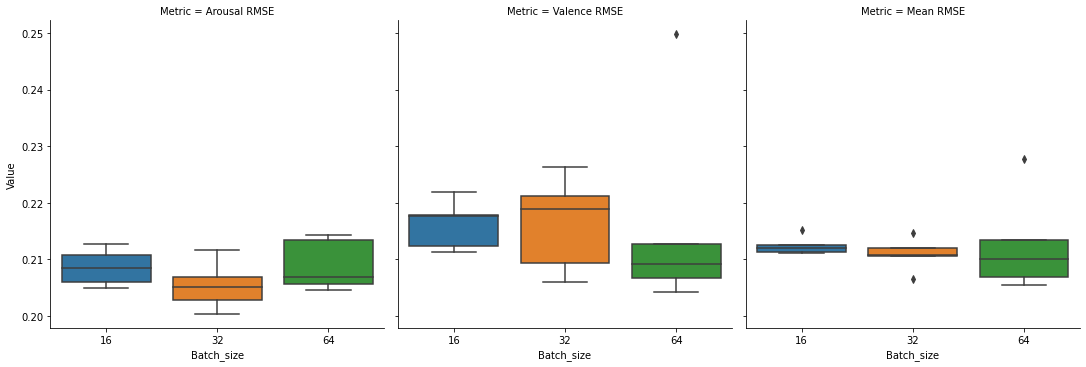

In [18]:
batch_size_results = pd.DataFrame(results)
sns.catplot(data = batch_size_results, x = "Batch_size", y = "Value", col = "Metric", kind = "box")

# Final evaluation of single models

In [19]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 32

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [20]:
final_rmse_values = []

for _ in tqdm(range(10)):
  model = ParallelGRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
  model = train_model(model, train_loader, epochs = 5)
  model.eval()
  
  train_a_rmse, train_v_rmse = get_rmse(model, train_X, train_a, train_v)
  valid_a_rmse, valid_v_rmse = get_rmse(model, valid_X, valid_a, valid_v)
  test_a_rmse, test_v_rmse = get_rmse(model, test_X, test_a, test_v)

  final_rmse_values.append({"Arousal_RMSE": train_a_rmse, "Valence_RMSE": train_v_rmse, "Dataset": "Train"})
  # final_rmse_values.append({"Arousal_RMSE": valid_a_rmse, "Valence_RMSE": valid_v_rmse, "Dataset": "Valid"})
  final_rmse_values.append({"Arousal_RMSE": test_a_rmse, "Valence_RMSE": test_v_rmse, "Dataset": "Test"})

100%|██████████| 10/10 [10:19<00:00, 61.98s/it]


In [21]:
final_rmse_df = pd.DataFrame(final_rmse_values)

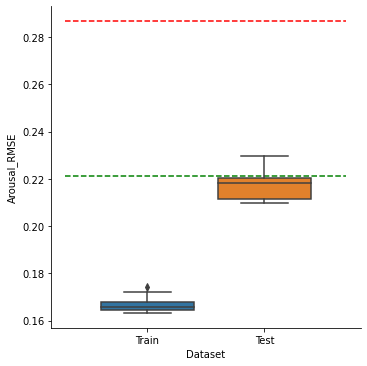

In [22]:
sns.catplot(data = final_rmse_df, x = "Dataset", y = "Arousal_RMSE", kind = "box")
plt.hlines(0.2211, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_a.mean() - test_a).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

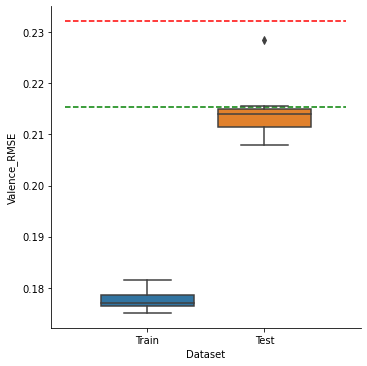

In [23]:
sns.catplot(data = final_rmse_df, x = "Dataset", y = "Valence_RMSE", kind = "box")
plt.hlines(0.2153, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_v.mean() - test_v).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

# Ensembles


In [24]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 32

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [25]:
class Ensemble():
  def __init__(self, models):
    self.models = models
  
  def __call__(self, x):
    a_preds, v_preds = [], []
    for model in models:
      model.eval()
      a, v = model(x)
      a_preds.append(a)
      v_preds.append(v)
    a_prediction = torch.stack(a_preds).mean(dim = 0)
    v_prediction = torch.stack(v_preds).mean(dim = 0)
    return a_prediction, v_prediction

In [27]:
EPOCHS = [1, 3, 5]
LEARNERS = [3, 5, 10]

for epochs, learners in itertools.product(EPOCHS, LEARNERS):
  models = [train_model(ParallelGRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = epochs) for _ in range(learners)]
  e = Ensemble(models)
  print(f"{learners} learners, {epochs} epochs", end = "\t")
  print_metrics(e)
  # rmse = get_rmse(e, valid_X, valid_a, valid_v)
  # print(f"{learners} learners after {epochs} epochs | Arousal RMSE {rmse[0]:.6f} | Valence RMSE {rmse[1]:.6f}")

3 learners, 1 epochs	0.17965269088745117	0.2039528787136078	0.21993954479694366	0.6270401232119072	0.5658115687437713	0.4072164755050214	0.2097884714603424	0.21696199476718903	0.2230709344148636	0.2714249672997142	0.23794532650259403	0.05771868282218817
5 learners, 1 epochs	0.17955084145069122	0.2020711749792099	0.21607597172260284	0.6274629169217424	0.573786355612151	0.42785980709323457	0.20919282734394073	0.21787819266319275	0.21905173361301422	0.27555638784893255	0.23149573564385606	0.09136816731915587
10 learners, 1 epochs	0.18902486562728882	0.20908118784427643	0.21720187366008759	0.5871117715626835	0.5437020314435086	0.42188185850527116	0.2094237059354782	0.21943603456020355	0.21735194325447083	0.2739564510507162	0.2204667717174903	0.10541503646244343
3 learners, 3 epochs	0.16258376836776733	0.20119795203208923	0.215333953499794	0.6945437591284297	0.577462055683674	0.43178262244907584	0.17983819544315338	0.2085610181093216	0.21473906934261322	0.46460426211118744	0.295817798432519

# Arousal and valence correlation

Parallel model shows lower correlation between arousal and valence than forked – this is desirable

In [28]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 32

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [29]:
real_df = pd.concat([
  pd.DataFrame({"Arousal": train_a, "Valence": train_v, "Method": "Truth", "Dataset": "Train"}),
  pd.DataFrame({"Arousal": test_a, "Valence": test_v, "Method": "Truth", "Dataset": "Test"}),
])

In [31]:
models = [train_model(ParallelGRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 5) for _ in tqdm(range(5))]
e = Ensemble(models)

pred_train_a, pred_train_v = e(train_X.cuda())
pred_test_a, pred_test_v = e(test_X.cuda())

parallel_df = pd.concat([
  pd.DataFrame({"Arousal": pred_train_a.cpu().detach(), "Valence": pred_train_v.cpu().detach(), "Method": "Parallel", "Dataset": "Train"}),
  pd.DataFrame({"Arousal": pred_test_a.cpu().detach(), "Valence": pred_test_v.cpu().detach(), "Method": "Parallel", "Dataset": "Test"}),
])


100%|██████████| 5/5 [04:58<00:00, 59.76s/it]


In [32]:
pred_2d_df = pd.concat([real_df, parallel_df])
pred_2d_df

,Arousal,Valence,Method,Dataset
0,-0.109388,-0.073341,Truth,Train
1,-0.114943,-0.074662,Truth,Train
2,-0.116414,-0.074078,Truth,Train
3,-0.118614,-0.078155,Truth,Train
4,-0.126458,-0.081589,Truth,Train
...,...,...,...,...
7495,0.348397,0.242859,Paralel,Test
7496,0.336263,0.240034,Paralel,Test
7497,0.356895,0.203580,Paralel,Test
7498,0.348744,0.213638,Paralel,Test


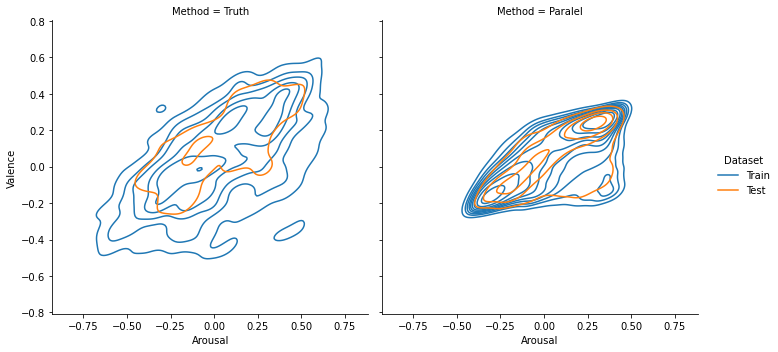

In [33]:
sns.displot(data = pred_2d_df, x = "Arousal", y = "Valence", hue = "Dataset", col = "Method", kind = "kde")
plt.show()

In [34]:
from scipy.stats import pearsonr 

for method in pred_2d_df.Method.unique():
  selected_df = pred_2d_df[pred_2d_df.Method == method]
  print(method, pearsonr(selected_df.Arousal, selected_df.Valence)[0])


Truth 0.5649186768954358
Paralel 0.7361634067771423


# Ensemble evaluation

In [35]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 32

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [38]:
ensemble_rmse_values = []

for _ in tqdm(range(5)):
  models = [train_model(ParallelGRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 5) for _ in range(5)]
  e = Ensemble(models)
  
  train_a_rmse, train_v_rmse = get_rmse(e, train_X, train_a, train_v)
  valid_a_rmse, valid_v_rmse = get_rmse(e, valid_X, valid_a, valid_v)
  test_a_rmse, test_v_rmse = get_rmse(e, test_X, test_a, test_v)

  ensemble_rmse_values.append({"Arousal_RMSE": train_a_rmse, "Valence_RMSE": train_v_rmse, "Dataset": "Train"})
  ensemble_rmse_values.append({"Arousal_RMSE": test_a_rmse, "Valence_RMSE": test_v_rmse, "Dataset": "Test"})



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [04:55<19:41, 295.49s/it]

 40%|████      | 2/5 [09:50<14:45, 295.31s/it]

 60%|██████    | 3/5 [14:45<09:50, 295.30s/it]

 80%|████████  | 4/5 [19:40<04:55, 295.02s/it]

100%|██████████| 5/5 [24:33<00:00, 294.71s/it]


In [39]:
ensemble_rmse_df = pd.DataFrame(ensemble_rmse_values)

In [44]:
final_rmse_df["Model"] = "Single (10)"
ensemble_rmse_df["Model"] = "Ensemble (5)"

rmse_df = pd.concat([final_rmse_df, ensemble_rmse_df])

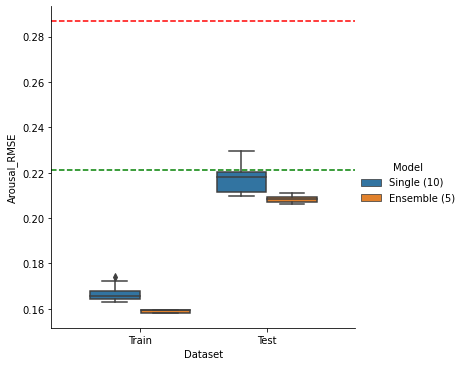

In [45]:
sns.catplot(data = rmse_df, x = "Dataset", y = "Arousal_RMSE", hue = "Model", kind = "box")
plt.hlines(0.2211, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_a.mean() - test_a).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

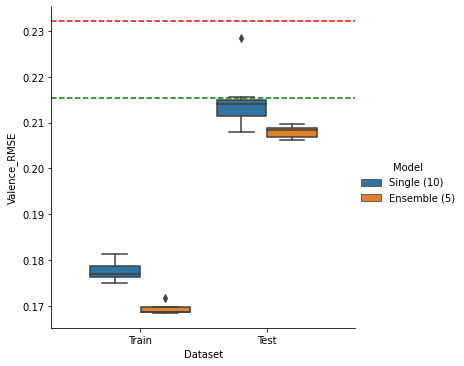

In [46]:
sns.catplot(data = rmse_df, x = "Dataset", y = "Valence_RMSE", hue = "Model", kind = "box")
plt.hlines(0.2153, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_v.mean() - test_v).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

In [47]:
rmse_df.groupby(["Dataset", "Model"]).agg(["mean", "std"])

Arousal_RMSE           Valence_RMSE          
                             mean       std         mean       std
Dataset Model                                                     
Test    Ensemble (5)     0.208500  0.001922     0.208026  0.001429
        Single (10)      0.217916  0.007031     0.214290  0.005548
Train   Ensemble (5)     0.158966  0.000804     0.169477  0.001399
        Single (10)      0.166842  0.003715     0.177646  0.002092

# Model for the app

In [48]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 32

ids = list(train_ids) + list(valid_ids) + list(test_ids)

train_X = (load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std
train_a = torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float)
train_v = torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float)

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [52]:
models = [train_model(ParallelGRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 5) for _ in range(5)]

In [55]:
for i, model in enumerate(models):
  torch.save(model.state_dict(), f"/content/drive/MyDrive/UJ/ML/Project/trained_models/parallel/model{i}")